In [1]:
import matplotlib.pyplot as plt

import  seaborn as sns
sns.set_style("darkgrid")

from ExperientalTools import *

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
%reload_ext autoreload
%autoreload 2

## Disclaimer
### The results in terms of MSE may be slightly different respect to the reports because at each execution there is a stochastic component. The convergence rate remains the same.

## Phase 1 - Get the dataset

In [2]:
(tr_x,tr_y) = prepare_dataset(train_path="../datasets/ML-CUP21-TR.csv",unique=True)

In [3]:
# dictionary to save the results
results={}

## Phase 2 - Define constants

In [4]:
SIZE_RESERVOIR = 100 # Size of resevoir (w1 dimensions)
LAMBDA_REG = 0.7 # Lambda regularization
MAX_ITER = 60000 # Max number of iterations
PRECISION = 1e-3 # precision on the norm of the gradient

## Phase 3 -  Fix the resevoir

In [5]:
resevoir = np.random.uniform(-1, 1, (SIZE_RESERVOIR, 10))
H = sigmoid(resevoir @ tr_x)
E = H @ H.T + np.power(LAMBDA_REG, 2) * np.eye(H.shape[0])

In [6]:
# Perform the condition number
condition_number = np.linalg.cond(E)
print(f"Condition number of E: {condition_number}")

Condition number of E: 72660.55445936939


## Phase 4 - Get optimal solution (oracle)

In [7]:
# Calculate the optimal solution
start_optimal = datetime.datetime.now()
w_star, _, _, _ = np.linalg.lstsq(E, H @ tr_y.T, rcond=-1)
end_optimal = (datetime.datetime.now() - start_optimal).microseconds

In [8]:
# Optional mse and time execution
results["Optimal"] = mse(w_star.T@H, tr_y), "-", "-", end_optimal

In [9]:
print("Mean square error: ", results["Optimal"][0])
print("Time: ", results["Optimal"][3])

Mean square error:  1.6884599874301736
Time:  2243


## Phase 5 - Obtain result with the direct method (Cholesky decomposition)

In [10]:
output = fit_cholesky(tr_x, tr_y, lambda_=LAMBDA_REG, resevoir=resevoir,w_star=w_star.T, mode="verbose")
f_star = output["model"](tr_x)

In [11]:
results["Cholesky"] = get_results(output["model"], tr_x, tr_y), output["gap_sol"], "-", output["elapsed_time"]

In [12]:
print("Cholesky Mean square error: ", results["Cholesky"][0])
print("Cholesky Relative Gap Sol: ", results["Cholesky"][1])
print("Cholesky Time elapsed: ", results["Cholesky"][3])

Cholesky Mean square error:  1.688459987430392
Cholesky Relative Gap Sol:  4.0965826002291274e-11
Cholesky Time elapsed:  50217


## Phase 6 - Obtain result with the iterative methods (FISTA and Gradient Descent - GD)

### Gradient Descent

In [13]:
output_gd = fit_gd(x_train=tr_x, y_train=tr_y, lambda_=LAMBDA_REG, max_inters=MAX_ITER,
                        eps=PRECISION, resevoir=resevoir, w_star=w_star.T, f_star=f_star, mode="verbose")
classical_gd, time = output_gd["model"], output_gd["elapsed_time"]

In [14]:
gd_gap_sol = output_gd["metrics"]["Gap_Sol"].tail(1).values[0]
gd_gap_pred = output_gd["metrics"]["Gap_Pred"].tail(1).values[0]
results["classical-GD"] = get_results(classical_gd, tr_x, tr_y), gd_gap_sol, gd_gap_pred, time

In [15]:
print("GD Mean square error: ", results["classical-GD"][0])
print("GD Relative Gap Sol: ", results["classical-GD"][1])
print("GD Relative Gap Pred: ", results["classical-GD"][2])
print("GD Time elapsed: ", results["classical-GD"][3])
print("GD Norm-Grad: ", output_gd["norm_grad"])

GD Mean square error:  1.713454167037203
GD Relative Gap Sol:  0.17985760197887482
GD Relative Gap Pred:  0.0028788144367495818
GD Time elapsed:  780073
GD Norm-Grad:  7.310579229241663


### FISTA

In [16]:
output_fista = fit_fista(x_train=tr_x, y_train=tr_y, lambda_=LAMBDA_REG, max_inters=MAX_ITER,
                  eps=PRECISION, resevoir=resevoir, w_star=w_star.T, f_star=f_star, mode="verbose")
fista, time = output_fista["model"], output_fista["elapsed_time"]

In [17]:
fista_gap_sol = output_fista["metrics"]["Gap_Sol"].tail(1).values[0]
fista_gap_pred = output_fista["metrics"]["Gap_Pred"].tail(1).values[0]
results["FISTA"] = get_results(fista, tr_x, tr_y), fista_gap_sol, fista_gap_pred, time

In [18]:
print("FISTA Mean square error: ", results["FISTA"][0])
print("FISTA Relative Gap Sol: ", results["FISTA"][1])
print("FISTA Relative Gap Pred: ", results["FISTA"][2])
print("FISTA Time elapsed: ", results["FISTA"][3])
print("FISTA Norm-Grad: ", output_fista["norm_grad"])

FISTA Mean square error:  1.6884581514615742
FISTA Relative Gap Sol:  8.888414305471694e-05
FISTA Relative Gap Pred:  1.4415117204442536e-06
FISTA Time elapsed:  896470
FISTA Norm-Grad:  0.0036566381141171535


### Plots

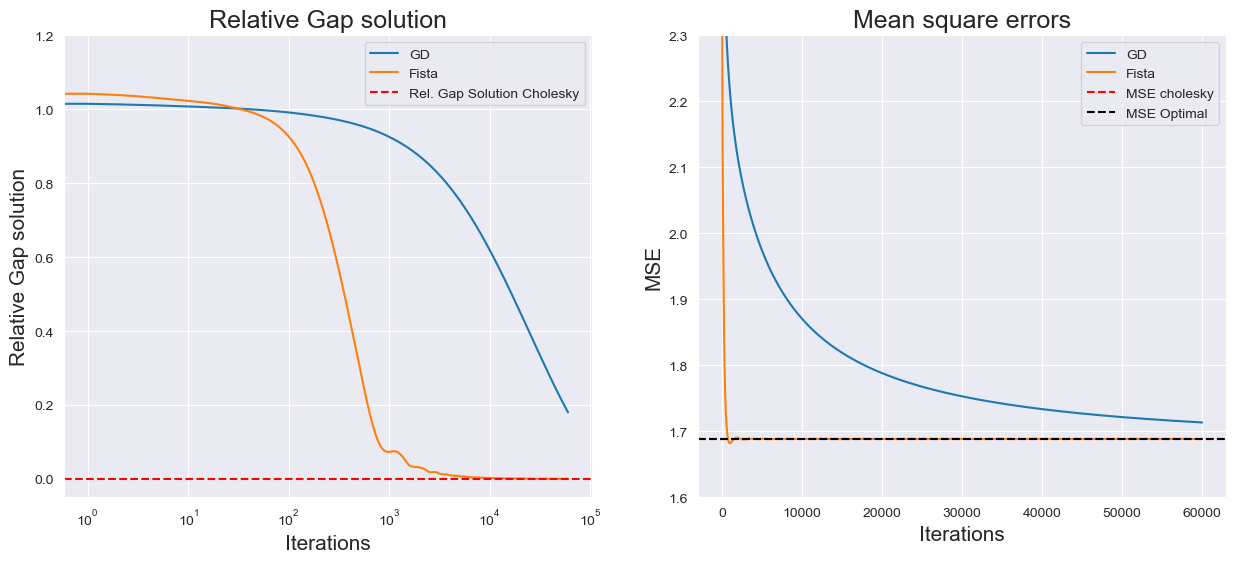

In [19]:
_, axs = plt.subplots(ncols=2,figsize=(15,6))

sns.lineplot(data=output_gd["metrics"], x=output_gd["metrics"].index, y="Gap_Sol", ax=axs[0], label="GD")
sns.lineplot(data=output_fista["metrics"], x=output_fista["metrics"].index, y="Gap_Sol", ax=axs[0], label="Fista")
axs[0].axhline(y=output["gap_sol"], label="Rel. Gap Solution Cholesky", color="red", linestyle="--")
axs[0].set_title("Relative Gap solution",fontsize=18)
axs[0].set_ylabel("Relative Gap solution",fontsize=15)
axs[0].set_xlabel("Iterations",fontsize=15)
axs[0].set_ylim([-0.05,1.2])
axs[0].set_xscale("log")
axs[0].legend()


sns.lineplot(data=output_gd["metrics"], x=output_gd["metrics"].index, y="MSE", ax=axs[1], label="GD")
sns.lineplot(data=output_fista["metrics"], x=output_fista["metrics"].index, y="MSE", ax=axs[1], label="Fista")
axs[1].axhline(y=results["Cholesky"][0], label="MSE cholesky", color="red", linestyle="--")
axs[1].axhline(y=results["Optimal"][0], label="MSE Optimal", color="black", linestyle="--")
axs[1].set_title("Mean square errors",fontsize=18)
axs[1].set_ylabel("MSE",fontsize=15)
axs[1].set_xlabel("Iterations",fontsize=15)
axs[1].set_ylim([1.6, 2.3])
axs[1].legend()

plt.show()


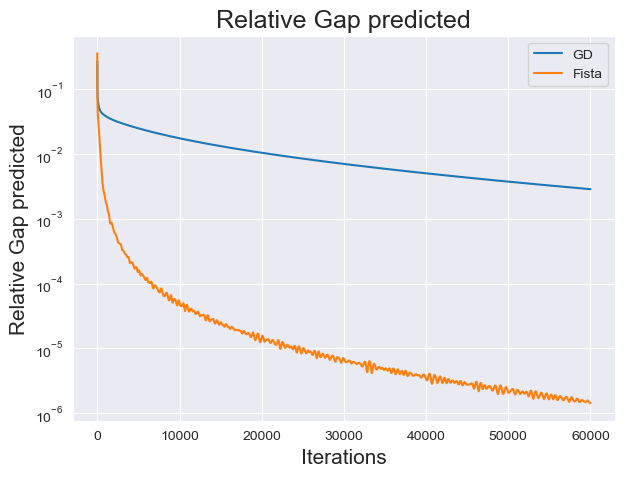

In [20]:
_, axs = plt.subplots(figsize=(7, 5))

sns.lineplot(data=output_gd["metrics"], x=output_gd["metrics"].index, y="Gap_Pred", ax=axs, label="GD")
sns.lineplot(data=output_fista["metrics"], x=output_fista["metrics"].index, y="Gap_Pred", ax=axs, label="Fista")
axs.set_title("Relative Gap predicted",fontsize=18)
axs.set_ylabel("Relative Gap predicted",fontsize=15)
axs.set_xlabel("Iterations",fontsize=15)
# axs.set_ylim([-0.02,0.05])
axs.set_yscale("log")
axs.legend()

plt.show()

## RECAP

In [21]:
print(f"{'Method' : ^20}{'MSE' : ^25}{'Rel. gap sol' : ^25}{'Rel. gap pred' : ^25}{'Time(microseconds)' : ^20}")

for k,v in results.items():
    print(f"{k : ^20}{v[0]:^25}{v[1] : ^25}{v[2] : ^25}{v[3] : ^20}")

       Method                  MSE                 Rel. gap sol             Rel. gap pred       Time(microseconds) 
      Optimal          1.6884599874301736                -                        -                    2243        
      Cholesky          1.688459987430392     4.0965826002291274e-11              -                   50217        
    classical-GD        1.713454167037203       0.17985760197887482     0.0028788144367495818         780073       
       FISTA           1.6884581514615742      8.888414305471694e-05   1.4415117204442536e-06         896470       
